### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from random import shuffle
import pandas as pd
import pickle

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Common Functions

#### Activation Functions

In [2]:
# Tanh Activation
def f(a):
    global beta
    return np.tanh(beta*a)


# Differentiation of tanh
def df(a):
    global beta
    return beta * (1 - f(a)**2)


# Softmax Activation
def softmax(a):
    a_exp = np.exp(a)
    return a_exp/np.sum(a_exp)

#### Forward Step

In [3]:
def forward(x, W):
    
# Performs forward step on one datapoint and calculates the outputs of nodes
# Inputs:
#     x --> one data point (numpy 1d array)
#     W --> current weights of model (list of numpy 2d arrays)
# Returns:
#     S --> The outputs of every node (list of numpy 1d arrays)
#     A --> The inputs to the activation function (list of numpy 1d arrays)

    S = []
    A = []
    
    # Input Layer
    A.append(x)
    s = np.insert(x, 0, 1)
    S.append(s)
    
    # Hidden Layers
    for layer in range(len(W)-1):
        a = np.matmul(W[layer].T, s)
        A.append(a)
        s = np.insert(f(a), 0, 1)
        S.append(s)
    
    # Output Layer
    a = np.matmul(W[-1].T, s)
    A.append(a)
    y = softmax(a)
    S.append(y)
    
    return S, A

def forward_reg(x, W):
    
# Performs forward step on one datapoint and calculates the outputs of nodes for a regression problem
# Inputs:
#     x --> one data point (numpy 1d array)
#     W --> current weights of model (list of numpy 2d arrays)
# Returns:
#     S --> The outputs of every node (list of numpy 1d arrays)
#     A --> The inputs to the activation function (list of numpy 1d arrays)
    
    # Input Layer
    s = np.insert(x, 0, 1)
    A = [x]
    S = [s]
    
    # Hidden Layers
    for layer in range(len(W)-1):
        a = np.matmul(W[layer].T, s)
        A.append(a)
        s = np.insert(f(a), 0, 1)
        S.append(s)
    
    # Output Layer
    a = np.matmul(W[-1].T, s)
    A.append(a)
    y = a          #linear activation function for the output layer here 
    S.append(y)
    
    return (S,A)

#### Backward Step

In [4]:
def backward(W, t, S, A, eta):
    
# Performs one backward step for one datapoint and calculates the required update for the weights
# Inputs:
#        W --> current weights of model (list of numpy 2d arrays)
#        t --> desired value of the output node
#        S --> The outputs of every node (list of numpy 1d arrays)
#        A --> The inputs to the activation function (list of numpy 1d arrays) 
#        eta --> learning rate
# Returns:
#        dW[::-1] --> the required update to the current weights 
    
    DW = []
    layers = list(range(len(W)-1, -1, -1))
    
    # Output Layer Local Gradient
    # If correct class:   (1 - s_k)
    # If incorrect class: -s_k
    # Generalized:        (t_k - s_k)
    delta = t - S[-1]
    
    # Hidden Layer Deltas and DWs
    for layer in layers:
        delW = eta*np.matmul(S[layer].reshape(-1, 1), delta.reshape(-1, 1).T)
        DW.append(delW)
        delta = np.multiply(np.matmul(W[layer][1:, :], delta), df(A[layer]))
    
    return DW[::-1]

#### One Epoch Update

In [5]:
def update_epoch(X, T, W, rule, eta, alpha, p1, p2):

# Updates the weights after every epoch 
# Inputs:
#        X --> The feature vectors
#        T --> desired value of the output node
#        W --> current weights of model (list of numpy 2d arrays) 
#        rule --> rule to be used for gradient descent  
#        eta --> learning rate
#        alpha --> momentum factor 
#        p1, p2 --> parameters of the Adam method
# Returns:
#        W --> the updated weight matrix
    
# Implements the delta rule without any momentum
    if rule == 'delta':

        for i in range(len(X)):
            
            x = X[i, :]
            try:
                t = T[i, :]
            except:
                t = T[i]
            
            (S, A) = forward(x, W)
            DW = backward(W, t, S, A, eta)
            newW = W.copy()
            for l in range(len(W)):
                newW[l] = W[l] + DW[l]
            W = newW.copy()

##############################################################                

# Implements the generalized delta rule
    elif rule == 'gendelta':

        oldDW = [np.zeros(weight.shape) for weight in W]
        
        for i in range(len(X)):
            x = X[i, :]
            try:
                t = T[i, :]
                (S, A) = forward(x, W)
            except:
                t = T[i]
                (S, A) = forward_reg(x, W)
            
            
            DW = backward(W, t, S, A, eta)

            newW = W.copy()
            for l in range(len(W)):
                newW[l] = W[l] + DW[l] + alpha*oldDW[l]
            
            W = newW.copy()

            oldDW = DW.copy()

##############################################################            

# Implements the Adam update rule
    elif rule == 'adam':
        
        Q_prev = [np.zeros(weight.shape) for weight in W]
        R_prev = [np.zeros(weight.shape) for weight in W]
        
        Q = [np.zeros(weight.shape) for weight in W]
        R = [np.zeros(weight.shape) for weight in W]
        
        Q_hat = [np.zeros(weight.shape) for weight in W]
        R_hat = [np.zeros(weight.shape) for weight in W]
            
        for i in range(len(X)):
            
            x = X[i, :]
            try:
                t = T[i, :]
            except:
                t = T[i]
            
            (S, A) = forward(x, W)
            DW = backward(W, t, S, A, eta)
                     
            for l in range(len(W)):
                g = -DW[l]/eta
                
                Q[l] = p1*Q_prev[l] + (1-p1)*(g)
                R[l] = p2*R_prev[l] + (1-p2)*(g**2)
            
            for l in range(len(W)):
                Q_hat[l] = Q[l]/(1-p1**(i+1))
                R_hat[l] = R[l]/(1-p2**(i+1))
            
            newW = W.copy()
            for l in range(len(W)):
                newW[l] = W[l] - eta*Q_hat[l]/(0.0001 + np.sqrt(R_hat[l]))
            
            W = newW.copy()
            
            Q_prev = Q.copy()
            R_prev = R.copy()
        
    return W

#### Plotting Functions

In [6]:
def surface_plot(x_train, y_train, W_trained, node_num, hidden_layer):
    
# Plots the surface of the output of a given node 
# Inputs
#     x_train -------> Training data matrix
#     y_train -------> Training data labels
#     W_trained -----> Trained Weigths (list of matrices)
#     node_num ------> Node number 
#     hidden_layer --> Hidden layer number 
# Returns
#     None

    x_min, x_max = x_train[:, 0].min() - .5, x_train[:, 0].max() + .5
    y_min, y_max = x_train[:, 1].min() - .5, x_train[:, 1].max() + .5
    h = .02  
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x = np.c_[xx.ravel(), yy.ravel()]
    y_pred = []
    
    for i in range(x.shape[0]):

        S, A = forward(x[i,:], W_trained)
        y_pred.append(S[hidden_layer][node_num-1])
        
    y_pred = np.array(y_pred).reshape(xx.shape)
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot_surface(xx, yy, y_pred, cmap='viridis', edgecolor='none')
    ax.set_title('Surface plot')
    plt.show()



def decision_region(x_train, y_train, W_trained):
    
# Plots the decision region of the trained model(weights)
# Inputs
#     x_train ----> Training data matrix
#     y_train ----> Training data labels
#     W_trained --> Trained Weigths (list of matrices)
# Returns
#     None
    
    x_min, x_max = x_train[:, 0].min() - .5, x_train[:, 0].max() + .5
    y_min, y_max = x_train[:, 1].min() - .5, x_train[:, 1].max() + .5
    h = .2  
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x = np.c_[xx.ravel(), yy.ravel()]
    y_pred = predict(x, W_trained)
    
    y_pred = np.array(y_pred).reshape(xx.shape)
    plt.pcolormesh(xx, yy, y_pred, cmap=plt.cm.Paired)
    
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary")
    plt.show()
    
def scatter_plot(y_true, y_pred):

# Plots a scatter plot of the true values vs the predicted values
    
    plt.figure(figsize=(7, 5))
    plt.xlabel('Target Output')
    plt.xlim(min(min(y_true), min(y_pred))-1, max(max(y_true), max(y_pred))+1)
    plt.ylim(min(min(y_true), min(y_pred))-1, max(max(y_true), max(y_pred))+1)
    plt.ylabel('Model Output')
    plt.title('Scatter Plot')
    plt.scatter(y_true, y_pred)
    
def plot_errors(errors):

# Plots the training error vs the epoch number 
    
    plt.figure(figsize=(10, 6))
    plt.xlabel('Epoch Number')
    plt.ylabel('Average Training Error')
    plt.title("Error vs Epoch")
    plt.plot(list(range(1,len(errors)+1)), errors)
    
def plot_desvsapprox(X, T, W):

# Plots the approximated function's surface in 3D along with the true training data points
# Inputs
#     X ----> Training data matrix
#     T ----> True Labels    
#     W ----> Weights

    x1_min = min(X[:,0])
    x2_min = min(X[:,1])
    x1_max = max(X[:,0])
    x2_max = max(X[:,1])
    y_pred = []
    n = 50
    x1 = np.linspace(x1_min, x1_max, num=n)
    x2 = np.linspace(x2_min, x2_max, num=n)
    X1, X2 = np.meshgrid(x1, x2)
    for i in range(n):
        for j in range(n):
            (S,A) = forward_reg([X1[i,j], X2[i,j]], W)
            y_pred.append(S[-1])
    Y = np.asarray(y_pred)
    Y = Y.reshape((n,n))
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Approximated Surface and Actual Data Points")
    surf = ax.plot_surface(X1,X2,Y)
    ax.scatter(X[:,0], X[:,1], T, c = 'r',marker="x")
    plt.show()

#### Training

In [7]:
def train_model(X, T, W, thresh=1e-2, rule='gendelta', eta=1e-4, alpha=0.9, p1=0.9, p2=0.9, max_iter=10000, display=20, plot_=False, max_err=0.155, locality=100, is_reg=False):

# Performs several weight updates till stopping criterion is satisfied to get the final weights of the model
# Inputs:
#        X --> The feature vectors
#        T --> desired value of the output node
#        W --> current weights of model (list of numpy 2d arrays) 
#        thresh --> threshold used as stopping criterion
#        rule --> rule to be used for gradient descent  
#        eta --> learning rate
#        alpha --> momentum factor 
#        p1, p2 --> parameters of the Adam method
#        max_iter --> maximum number of iterations before which training stops
#        display --> controls the verbosity, displays after every (100/display)% of max_iter completed
#        plot_ --> whether to plot or not 
#        max_err --> maximum error that can be tolerated 
#        locality --> number of error terms to be considered locally for moving average 
#        is_reg --> indicator for whether the problem is a regression problem
# Returns:
#        W --> the final weight matrix
#        errors --> list of errors 

    old_err = 0
    err = np.inf
    epoch = 0
    
    if is_reg == True:
        errors = [sse_error(X, T, W)]
        local_err_profile = [sse_error(X, T, W)]
    else:
        errors = [entropy_error(X, T, W)]
        local_err_profile = [entropy_error(X, T, W)]
        
    prev_loc_mean = np.mean(local_err_profile)
    
    if plot_ == True:
        label = np.argmax(T, axis = 1)
        layers = len(W) # Number of Hidden layers + Output layer 
        nodes = []
        for w in W:
            nodes.append(w.shape[1])
        
    while epoch <= max_iter:
        
        order = list(range(len(X)))
        np.random.shuffle(order)
        
        epoch += 1
        
        try:
            T_shuffled = T[order, :]
        except:
            T_shuffled = T[order]
            
        W = update_epoch(X[order, :], T_shuffled, W, rule=rule, eta=eta, alpha=alpha, p1=p1, p2=p2)
        
        if is_reg == True:
            err = sse_error(X, T, W)
        else:
            err = entropy_error(X, T, W)
            
        errors.append(err)
        
        if (epoch)%(int(max_iter/display)) == 0:
            print(round(epoch/max_iter*100, 3), '% of Max Iter Done - Current Error =', round(err, 7))

# Stopping Criteria
# Check changes to moving average (window_size=locality) of error after epochs
# Check if error less than max_err

        if len(local_err_profile) > locality:
            local_err_profile = local_err_profile[1:]

        local_err_profile.append(err)        
        
        loc_err_mean = np.mean(local_err_profile)
        
        if abs(loc_err_mean-prev_loc_mean)/loc_err_mean < thresh and (err<max_err):
            print('Converged')
            break
            
        prev_loc_mean = loc_err_mean
        
        old_err = err

# Plots the outputs of the nodes

        if plot_ == True and epoch in [1, 2, 10, 50]:
            for l in range(1, layers+1):
                for n in range(1, nodes[l-1]+1):
                    if l!=layers:
                        print('Epoch: {0}, Hidden Layer: {1}, Node: {2} '.format(epoch, l, n))
                    else:
                        print('Epoch: {0}, Output Layer, Node: {1} '.format(epoch, n))
                    surface_plot(X, label, W, n, l)
    
    return W, errors

#### Metrics

In [8]:
def confusion_matrix(T, Y):
    
# Prints and returns the confusion matrix given the predictions and the the true labels
# Inputs
#     T --> True Labels (One hot encoded) numpy 2d array
#     Y --> Predicted Labels (One hot encoded) numpy 2d array
# Returns
#     matrix --> Confusion Matrix with rows corresponding to true classes 
#                and columns corresponding to predicted classes

    t = np.where(T==1)[1]
    classes = np.unique(t)
    
    matrix = np.zeros([len(classes), len(classes)])
    
    for i in classes:
        correct_ind = np.where(t==i)[0]
        for j in classes:
            try:
                matrix[i, j] = len([1 for ind in correct_ind if Y[ind] == j])
            except:
                pdb.set_trace()
    
    return matrix

#### Preprocessing Functions

In [9]:
def PCA(X, var_exp=0.97):
    
# Computes the reduced space representation of the given matrix to retain 
# variance explained as specified
# Inputs
#     X --> Data, numpy 2d array
#     max_var --> Maximum variance explained after dimensional reduction (float)
# Returns
#     X_PCA --> PCA transformed data
#     PCAmodel --> Tupple of mean, standard deviation and principal components of X
    
    # Mean-Variance Scaling 
    meanX = np.mean(X, 0)
    stdX = np.std(X, 0)

    X_norm = (X - meanX)/stdX
    U, S, Vh = np.linalg.svd(X_norm, full_matrices=False)

    # Deciding number of components for required variance explained
    k = 0
    exp_var = 0
    var = S**2/np.sum(S**2)

    while exp_var < var_exp:
        k += 1
        exp_var = np.sum(var[:k])

    # Transforming data based on PCs
    PCs = Vh.T[:, :k]
    X_PCA = np.matmul(X_norm, PCs)

    PCAmodel = (meanX, stdX, PCs)

    return X_PCA, PCAmodel


def PCA_fit(X, PCAmodel):

# Transforms the given data according to the PCAmodel
# Inputs
#     X --> Data matrix, numpy 2d array
#     PCAmodel --> Tupple of mean, standard deviation and principal components
# Returns
#     X_PCA --> PCA transformed data matrix
    
    meanX = PCAmodel[0]
    stdX = PCAmodel[1]
    PCs = PCAmodel[2]
    
    X_norm = (X-meanX)/stdX
    X_PCA = np.matmul(X_norm, PCs)
    
    return X_PCA


def data_preprocess(X_train, X_test=None, var_exp=0.97):

# Preprocesses the given training and/or test data by performing standard 
# scaling (for PCA) and PCA transformation
# Inputs
#     X_train --> Training Data, PCA is fit on this
#     X_test --> Test data, if not None, transformed according to PCA fit on train data
#     var_exp --> Variance to be explained by the model
# Returns
#     X_pca_train --> PCA trained and transformed data matrix
#     X_pca_test --> PCA transformed matrix (or nothing if X_test == None)

    stdX = np.std(X_train, 0)
    useless_cols = np.where(stdX==0)
    X_reduced = np.delete(X_train, useless_cols, 1)
    
    # Train and transform test data
    (X_pca_train, PCAmodel) = PCA(X_reduced, var_exp)
    
    # Transform test data (if present)
    if X_test.any() != None:
        X_reduced_test = np.delete(X_test, useless_cols, 1)
        X_pca_test = PCA_fit(X_reduced_test, PCAmodel)
    
        return X_pca_train, X_pca_test
    
    return X_pca_train        

#### Error Functions

In [10]:
def entropy_error(X, T, W):

# Cross entropy loss function for classification
# Inputs
#     X --> Data Matrix
#     T --> Class labels (one hot encoded)
#     W --> Weigths Weigths (list of matrices)
# Returns
#     err/len(X) --> Cross entropy error (float)

    err = 0
    for i in range(len(X)):
        
        x = X[i, :]
        t = T[i, :]
        
        (S, A) = forward(x, W)
        
        # Output of the last layer for the correct class is obtained
        y = S[-1][np.where(t==1)[0][0]]
        err += -np.log(y)
    
    return err/len(X)

def sse_error(X, T, W):
    
# SSE loss function for function approximation
# Inputs
#     X --> Data Matrix
#     T --> Class labels (one hot encoded)
#     W --> Weigths Weigths (list of matrices)
# Returns
#     err/len(X) --> MSE (float)

    err = 0
    for i in range(len(X)):
        
        x = X[i, :]
        t = T[i]
        
        (S, A) = forward_reg(x, W)
        y = S[-1][0]
        err += 0.5*(y-t)**2
    
    return err/len(X)

#### Prediction on Test Data

In [11]:
def predict(X, W, is_reg=False):

# Performs prediction on X, based on the weights W
# Inputs
#     X --> Data Matrix
#     W --> Weigths (list of matrices)
# Returns
#     Y --> Predicted class labels (not one hot encoded)

    Y = []
    
    for i in range(len(X)):
            
        x = X[i, :]
        
        if is_reg == True:
            (S, A) = forward_reg(x, W)
            Y.append(S[-1][0])
        else:
            (S, A) = forward(x, W)
            # Index of the node with maximum output value in 
            # the last layer is the class label
            Y.append(np.argmax(S[-1]))
        
    return Y

-----------------------------------------------
## Question 2
-----------------------------------------------

### Test Data Import

In [13]:
data = pd.read_csv('testgroup3.csv')
x_test = data.drop('label', axis = 1).values
label = data['label'].values

#One hot encoding
N = x_test.shape[0]
K = len(np.unique(label))

t_test = np.zeros([N, K])
for i in range(N):
    t_test[i, int(label[i])] = 1
    
W = pickle.load(open('Trained Weights/W_Q2.sav', 'rb'))

In [15]:
beta = 1

# Architecture
n_hidden_layers = 2
K = len(np.unique(label))
N = len(x_all)
M = 10
J = 10

# Test Data Metrics
Y_test = predict(x_test, W)
print('\nTest Data\n')
cf = confusion_matrix(t_test, Y_test)
print(cf)
print('Test Accuracy =', np.sum(np.diag(cf))/np.sum(cf))


Test Data

[[28.  2. 11.]
 [ 0. 38.  2.]
 [ 7.  0. 33.]]
Test Accuracy = 0.8181818181818182


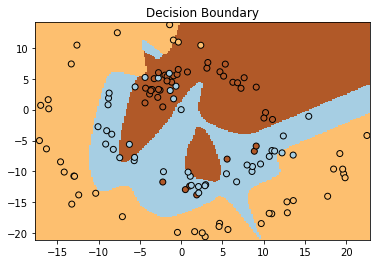

In [16]:
label_test = np.argmax(t_test, axis = 1)
decision_region(x_test, label_test, W)